In [4]:
# Value Strategy 

## 1. Import List of Libraries 

In [423]:
import pandas as pd
import numpy  as  np
from datetime import datetime, timedelta

## Final Portfolio Optimization code 
from cvxpy import *
import cvxpy as cp

import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from yahoo_finance import Share
import random

In [4]:
cd ..

/Users/ankitrawat/Desktop/smu/Classes/Term5/QF_621_QuantStrategies/Project


## 2. Upload Files - FX Rates  - G10 Currencies 

In [424]:
fx_df = pd.read_csv("G10_FX_CLOSE.csv")
fx_df["DATE"] = pd.to_datetime(fx_df["DATE"])
fx_df = fx_df.set_index('DATE')
fx_df.columns
fx_df = fx_df.iloc[:,-10:-1]
fx_ = fx_df.copy()

In [425]:
fx_df.columns = ['JPY','GBP','CAD','AUD', 'NZD', 'CHF', 'DKK', 'NOK','SEK']
fx_df.head(2)

,JPY,GBP,CAD,AUD,NZD,CHF,DKK,NOK,SEK
DATE,,,,,,,,,
2011-03-01,81.74,0.6456,0.9938,0.9835,1.2930,0.9334,5.5788,5.8277,6.7004
2011-04-01,82.04,0.6416,0.9983,0.9949,1.3045,0.9486,5.6006,5.8631,6.7233


## 3. Upload Files - PPP Rates  - G10 Countries  

In [426]:
ppp_df = pd.read_csv("PPP.csv")
ppp_df['Year']=pd.to_datetime(ppp_df["Year"], format='%Y')
ppp_df = ppp_df.set_index('Year')
ppp_df.index = ppp_df.index.year
ppp_df.head(2)
fx_df_nominal = fx_df.copy()

## 4. Convert Nominal FX rates into real interest rates --> Nominal / Real Interest Rates 

In [427]:
fx_df_nominal = fx_df.copy()
for i in fx_df.index.year.unique():
    for j in fx_df.columns:
        fx_df[j][fx_df.index.year == i] = (fx_df[j][fx_df.index.year == i])/(ppp_df[j][ppp_df.index == int(i-1)].values)

## 4. Split Data - Test  (  2010 - 2019/11) and Validation (2020 - 2020/12)

In [428]:
fx_df_nominal.head(2) , fx_df.head(2)
train_size = int(fx_df.shape[0] * 0.83)

# Data Split   -  Validation Datat
fx_df_nominal_test = fx_df[(fx_df.index.year < 2020) & (fx_df.index.year > 2010)]
fx_df_nominal_train = fx_df.iloc[(fx_df.index.year == 2020)]

# Data Split - Real  - Test Data
fx_df_real_test = fx_df[(fx_df.index.year < 2020) & (fx_df.index.year > 2010)]
fx_df_real_train = fx_df.iloc[(fx_df.index.year == 2020)]

## 5.Generating Daily Returns 

In [22]:
"""
fx_df_nominal.head(2) , fx_df.head(2)
train_size = int(fx_df.shape[0] * 0.8)

# Data Split   -  Validation Datat
fx_df_nominal_test = fx_df_nominal.iloc[:train_size,:]
fx_df_nominal_train = fx_df_nominal.iloc[train_size:,:]



# Data Split - Real  - Test Data
fx_df_real_test = fx_df.iloc[:train_size,:]
fx_df_real_train = fx_df.iloc[train_size:,:]

"""
# Generating returns
returns = fx_df_nominal_test/fx_df_nominal_test.shift(-1) - 1
returns.dropna()

signal_temp = fx_df_nominal_test/fx_df_real_test - 1
signal_temp

signal = pd.DataFrame(np.zeros(shape = signal_temp.shape), columns = signal_temp.columns, index = signal_temp.index)
top_n = 2


for index, row in signal_temp.iterrows():
        signal.loc[index, row.nlargest(top_n).index] = 1      
for index, row in signal_temp.iterrows():
        signal.loc[index, row.nsmallest(top_n).index] = -1
        
asset_returns = signal * returns
portfolio_returns = (asset_returns.sum(axis = 1))/4
cum_returns = np.cumprod((1 + portfolio_returns))
cum_returns = cum_returns.shift(1)
cum_returns[0] = 1

## Generating Trading Singnal  - Select top 3 and bottom three 

In [420]:
from sklearn.preprocessing import StandardScaler
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))

    # cap holding at 1 and -1
    return np.clip(t_stat, a_max=1, a_min=-1)

In [421]:
## Buy undervalued top three and Sell Overvalues top three 

In [422]:
Buy_Undevalued = GetTradingSignal(fx_df).sort_values(ascending = True).head(3)
Sell_OverValued= GetTradingSignal(fx_df).sort_values(ascending = False).head(3)
print ("\nBuy : \n{}".format(Buy_Undevalued))
print ("\nSell :\n{}".format(Sell_OverValued))


Buy : 
CHF   -1.000000
SEK   -1.000000
AUD   -0.750467
dtype: float64

Sell :
NOK   -0.129373
CAD   -0.244140
NZD   -0.593122
dtype: float64


## Data Normalization

In [ ]:
data = StandardScaler().fit_transform(GetTradingSignal(fx_df).values.reshape(-1,1))

In [419]:
data

array([[ 0.87825749],
       [-1.64122048],
       [ 0.5375986 ],
       [ 0.64521884],
       [-1.30660834],
       [ 0.87825749],
       [ 0.87825749],
       [-1.20999328],
       [ 0.34023218]])

## Buy undervalued top three and Sell Overvalues top three 

In [60]:
final_Normalized_weight = []
symbol_port = fx_df_real_test.columns
for i,j in zip(symbol_port,data):
    final_Normalized_weight.append([i,j])
    
df_Tscore  = pd.DataFrame(final_Normalized_weight)
df_Tscore.columns = {"Currency", "Score"}
Buy_Undevalued = df_Tscore.sort_values( by = "Score",ascending = True).head(3)
Sell_OverValued= df_Tscore.sort_values(by = "Score",ascending = False).head(3)
print ("\nBuy : \n{}".format(Buy_Undevalued))
print ("\nSell :\n{}".format(Sell_OverValued))


Buy : 
  Score              Currency
3   AUD  [0.6452188449131557]
2   CAD  [0.5375986040173378]
5   CHF   [0.878257492650972]

Sell :
  Score               Currency
8   SEK   [0.3402321806023221]
4   NZD   [-1.306608341328997]
7   NOK  [-1.2099932837553367]


## DataFrame "all_df" with list of buy currency and sell currency 

In [95]:
Buy_Undevalued["Action"] = "1"
Sell_OverValued["Action"] = "-1"
fx_buy_sell = pd.concat([Buy_Undevalued,Sell_OverValued],axis=0).drop("Currency", axis =1)
fx_buy_sell.columns = {"Currency","Action"}

df_Buy_FX = fx_df_real_train[fx_buy_sell[fx_buy_sell["Currency"] == '1']["Action"].values]
df_Sell_FX =fx_df_real_train[fx_buy_sell[fx_buy_sell["Currency"] == '-1']["Action"].values]

all_df = pd.concat([df_Buy_FX,df_Sell_FX],axis=d1)
all_df.head(10)
df_Sell_FX

,SEK,NZD,NOK
DATE,,,
2020-01-01,0.118828,0.717391,0.092116
2020-02-01,0.118809,0.719755,0.092270
2020-03-01,0.119267,0.723855,0.092680
2020-06-01,0.119294,0.722649,0.092249
2020-07-01,0.119970,0.726122,0.092858
...,...,...,...
2020-12-25,0.105111,0.677788,0.090515
2020-12-28,0.105011,0.679428,0.090601
2020-12-29,0.104104,0.674653,0.090430


In [ ]:
"""
fx_df_nominal.head(2) , fx_df.head(2)
train_size = int(fx_df.shape[0] * 0.8)

# Data Split   -  Validation Datat
fx_df_nominal_test = fx_df_nominal.iloc[:train_size,:].iloc[-1].sort_values(ascending=False)
fx_df_nominal_train = fx_df_nominal.iloc[train_size:,:].iloc[-1].sort_values(ascending=False)



# Data Split - Real  - Test Data
fx_df_real_test = fx_df.iloc[:train_size,:].iloc[-1].sort_values(ascending=False)
fx_df_real_train = fx_df.iloc[train_size:,:].iloc[-1].sort_values(ascending=False)
"""

## Dollar Neutral Portfolio Creation 

'''
Action / Currency / Variable 
    1. Buy : AUD ->  w[0]
    2. BUy : CAD ->  w[1] 
    3. Buy : CHF ->  w[2] 
    4. Sell :SEK  -> w[3]
    5. Sell :NZD  -> w[4]
    6. Sell : NOK -> w[5] 

- Constraints 

    1. w[0],w[1],w[2] ->  Buy and   w[3],w[4],w[5] : Sell
    2. Sum of weight is allocated across all currencies is 1 
    3. Weighted of all currencies is between -1 to 1 


- Optimization: 
    * Maximize ( expecgted Retrun - Gamma * Risk)


'''

In [288]:
## Data 
all_df.columns  = ["SEK","NZD","NOK","AUD","CAD","CHF"]

## Constant Values 
exp_return = 0.4 
df_ =  all_df
df_ = all_df.pct_change().dropna()

## Convariance 
cov_mat = df_.cov()
Sigma = cov_mat.values # np.asarray(cov_mat.values)

## Varaible Creation 
w = cp.Variable(len(df_.columns))

## mu 
mu = np.array([exp_return]*len(cov_mat)) # mu is the vector of expected returns.
mu = mu.reshape(-1,1)

## Expected Return 
expected_return = mu.T@w 


num_stocks = len(cov_mat)
gamma = Parameter(nonneg=True)
gamma.value = 1

## Risk Calculation 
risk = quad_form(w, Sigma)


## Constraints 
opt_constraints = [w[0] >= -1,w[0] <= 0,w[1] >= -1,w[1] <= 0,w[2] <= 1,w[2] <= 0,w[2] <= 1, \
                   w[3] >= 0,w[3] <= 1,w[4] >= 0,w[4] <= 1,w[5] >= 0,w[5] <= 1, \
                   sum(w) == 1] 


## Maximize -> Maximize(expected_return - gamma*risk)
prob = cp.Problem(cp.Maximize(expected_return - gamma*risk),constraints=opt_constraints)
prob.solve()

print ("Total Weight - Dollar Neutral  : {}".format( w[0].value + w[1].value + w[2].value + w[3].value + w[4].value + w[5].value))

weights_df = pd.DataFrame([w[0].value,w[1].value,w[2].value,w[3].value,w[4].value,w[5].value],index = {"SEK","NZD","NOK","AUD","CAD","CHF"})
weights_df = weights_df.rename(columns = {0 : "Weight"})
print ("\nCurrency Weight : \n")
print (weights_df)
weights_df.loc["CHF"]
list(weights_df.index.values)

Total Weight - Dollar Neutral  : 1.0000000000000004

Currency Weight : 

           Weight
CHF -2.384033e-01
SEK -6.994608e-17
NOK -2.924431e-16
AUD  6.330878e-01
NZD  6.053155e-01
CAD  1.341785e-16


['CHF', 'SEK', 'NOK', 'AUD', 'NZD', 'CAD']

## Positon Creation on Day =0  , Tracking retrun in 2020
- Total Cash = 10000

In [329]:
Total_Cash = 10000
fx_.columns = fx_.columns.str.strip()
fx_df = fx_[fx_.index.year == 2020][weights_df.index.values]
Daily_PNL = pd.DataFrame(columns = list(weights_df.index.values))
Cumulative_PNL = pd.DataFrame(columns = list(weights_df.index.values))

fx_return = fx_df.pct_change()
## on Trading Day  Position 

Daily_ = {"CHF": fx_df["CHF"].iloc[0]* weights_df.loc["CHF"][0]*Total_Cash,\
          "SEK": fx_df["SEK"].iloc[0]* weights_df.loc["SEK"][0]*Total_Cash,\
          "SEK": fx_df["NOK"].iloc[0]* weights_df.loc["NOK"][0]*Total_Cash,\
          "AUD": fx_df["AUD"].iloc[0]* weights_df.loc["AUD"][0]*Total_Cash,\
          "NZD": fx_df["NZD"].iloc[0]* weights_df.loc["NZD"][0]*Total_Cash,\
          "CAD": fx_df["CAD"].iloc[0]* weights_df.loc["CAD"][0]*Total_Cash}
Daily_PNL = pd.DataFrame(Daily_,index={1})

Cumulative_PNL =  Daily_PNL * 0 
Daily_PNL

#Daily_PNL.append(Daily_,ignore_index=True)

,CHF,SEK,AUD,NZD,CAD
1,-2305.359781,-2.567826e-11,9022.134383,9002.251765,1.742577e-12


In [327]:
fx_df_return = fx_df.pct_change().dropna()
Position = 0
for i in weights_df.index:
    Daily_PNL[i+_"DailyPNL"] = 


CHF
SEK
NOK
AUD
NZD
CAD


In [306]:
fx_df["NOK"].iloc[0]* weights_df.loc["NOK"][0]

-2.567826061460633e-15

In [374]:
fx_df_retun.columns

Index(['CHF', 'SEK', 'NOK', 'AUD', 'NZD', 'CAD'], dtype='object')

In [381]:
Total_Cash = 10000
data_df = fx_df[fx_df.index.year == 2020][['CHF', 'SEK', 'NOK', 'AUD', 'NZD', 'CAD']]
position = []
for i in weights_df.index:
    print(i)
    Amount = Total_Cash * data_df[i].iloc[0] * weights_df.loc[i][0]
    position.append([i,Amount])

print("Total Position on day 0 : {} ".format(position))

CHF
SEK
NOK
AUD
NZD
CAD
Total Position on day 0 : [['CHF', -2305.3597810979013], ['SEK', -6.5503101370631746e-12], ['NOK', -2.567826061460633e-11], ['AUD', 9022.134382857346], ['NZD', 9002.251764838411], ['CAD', 1.7425768030858799e-12]] 


Currency : CHF , Currency Weight -2384.032865664841 
Currency : SEK , Currency Weight -6.99460761261658e-13 
Currency : NOK , Currency Weight -2.924431202264803e-12 
Currency : AUD , Currency Weight 6330.878101787486 
Currency : NZD , Currency Weight 6053.154763877361 
Currency : CAD , Currency Weight 1.3417854801616077e-12 


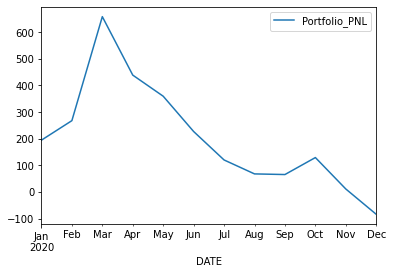

In [418]:
fx_df_return = fx_df.pct_change().dropna()
fx_df_retun.apply(lambda x : x.sum(axis =0))

#fx_df_retun["Daily_Return_CHF"] = fx_df_retun["CHF"].iloc[0] * 

cumulativePNL_df = fx_df_retun.cumsum()
for i in fx_df_retun.columns:
    print("Currency : {} , Currency Weight {} ".format(i,weights_df.loc[i][0]*Total_Cash))
    cumulativePNL_df["PNL_"+i] = cumulativePNL_df[i].apply(lambda x : x * (weights_df.loc[i][0]*Total_Cash))


#cumulativePNL_df["Portfolio_PNL"] =   cumulativePNL_df[""].apply(lambda x : x.sum(axis ) )
cumulativePNL_df["Portfolio_PNL"] = cumulativePNL_df[["PNL_CHF","PNL_SEK","PNL_NOK","PNL_AUD","PNL_CAD"]].sum(axis =1)
cumulativePNL_df[["Portfolio_PNL"]].resample('M').mean().plot()